# Safe Drinking Water and Mortality               


- Antonio Gutiérrez
- Jingxi Lu
- Yanan Cui
- Simin Zhang
- Yushi Zhang

https://github.com/tonogutierrez/Rennes-Data-Programming.git


**Why does it matter?**
- Access to safe drinking water is a fundamental human right
- Unsafe WASH services cause millions of preventable deaths annually
- Understanding this relationship is crucial for effective public policies
- WHO data allows for comparative analyses across countries and regions.

**Research Questions:**
1. How has access to safe drinking water evolved globally (2000-2022)?
2. Which countries have the highest mortality rates from unsafe WASH?
3. Is there a correlation between access to water and mortality?
4. Are there significant differences by gender and urbanization?

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings

#Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 11

print("Libraries ready")

Libraries ready


In [134]:
#Obtaining the data
# WHO – Safe Drinking Water Coverage 2000–2022
fWater = "1548EA3_ALL_LATEST.csv"  
#(WHO – WASH Mortality) 2019
fMort  = "ED50112_ALL_LATEST.csv" 

#We use a try in order to load the data
#If there is a issue, we can know what's going on 
try:
    water = pd.read_csv(fWater,encoding='utf-8')
    print("Water: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")

try:
    mort = pd.read_csv(fMort,encoding='utf-8')
    print("Mortality: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")  


Water: ready
Mortality: ready


In [135]:
#Create a function to clean data
def advancedDataCleaning(df, datasetName = "dataset"):
    print(f"Advanced cleaning: {datasetName} ===")
    print(f"Before: {df.shape}")

    #Remove empty rows
    #We use dropna(how: all) because if all values are NA, drop that row or column 
    dfClean = df.dropna(how='all')
    print(f"After eliminating empty row: {dfClean.shape}")
    
    #Remove columns with 33% empty values
    limit = 0.33 * len(dfClean)
    #We count the columns where they are less than 33
    colsToKeep = dfClean.columns[dfClean.isna().sum() <= limit]
    dfClean = dfClean.loc[:,colsToKeep]
    print(f"After eliminating columns with > 33% null: {dfClean.shape}")

    #Remove duplicates
    dfClean = dfClean.drop_duplicates()
    print(f"After eliminating duplicates values: {dfClean.shape}")

    #Impute missing numeric values ​​with mean
    #We use select_dtypes in order to have a subset of the DataFrame's columns 
    #We use number to select all numeric types
    #Also, at the end we use .columns to know the names of the columns
    numCols = dfClean.select_dtypes(include='number').columns
    for col in numCols:
        #We count the null values
        #dfClean[col].isna() -> True where there are NaN
        #.sum() how many trues we have
        if dfClean[col].isna().sum() > 0:
            meanVal = dfClean[col].mean()
            dfClean[col] = dfClean[col].fillna(meanVal)
            print(f"Imputed {col} with a media of: {meanVal:.2f}")

    #Mode
    catCols = dfClean.select_dtypes(include='object').columns
    for col in catCols:
        if dfClean[col].isna().sum() > 0:
            modeVal = dfClean[col].mode()[0] if not dfClean[col].mode().empty else "UNKNOWN"
            dfClean[col] = dfClean[col].fillna(modeVal)
            print(f"Imputed {col} with a mode; {modeVal}")

    print(f"Final form: {dfClean.shape}")
    print(dfClean.isna().sum().sum())

    return dfClean
water = advancedDataCleaning(water, "Water")
mort = advancedDataCleaning(mort, "Moartality")


Advanced cleaning: Water ===
Before: (7080, 13)
After eliminating empty row: (7080, 13)
After eliminating columns with > 33% null: (7080, 13)
After eliminating duplicates values: (7080, 13)
Imputed PERCENT_POP_N with a media of: 58.76
Final form: (7080, 13)
0
Advanced cleaning: Moartality ===
Before: (552, 13)
After eliminating empty row: (552, 13)
After eliminating columns with > 33% null: (552, 13)
After eliminating duplicates values: (552, 13)
Final form: (552, 13)
0


In [136]:
#Standardize a WHO dataset (water or mortality) to a common schema
#Returns Clean, standardized table ready for joins, EDA, and models.
def standardizeWhoData(df, valueAlias, dataset_type="water"):
    if dataset_type == "water":
        colsMap = {
            'GEO_NAME_SHORT': 'country',
            'DIM_TIME': 'year',
            'PERCENT_POP_N': valueAlias,
            'DIM_DEG_URB': 'urbanization',
            'DIM_GEO_CODE_TYPE': 'geo_type'
        }
    else:
        colsMap = {
            'GEO_NAME_SHORT': 'country',
            'DIM_TIME': 'year',
            'RATE_PER_100000_N': valueAlias,
            'DIM_SEX': 'sex',
            'DIM_GEO_CODE_TYPE': 'geo_type'
        }
    
    available = [c for c in colsMap.keys() if c in df.columns]
    out = df[available].copy()
    out.columns = [colsMap[c] for c in available]

    #Convert argument to a numeric type    
    out['year'] = pd.to_numeric(out['year'], errors='coerce').astype('Int64')
    out[valueAlias] = pd.to_numeric(out[valueAlias], errors='coerce')
    
    out = out.dropna(subset=['country', 'year', valueAlias])
    out = out.drop_duplicates().reset_index(drop=True)
    
    if dataset_type == "water":
        out = out[(out[valueAlias] >= 0) & (out[valueAlias] <= 100)]
    else:
        out = out[out[valueAlias] >= 0]
    
    return out

waterStd = standardizeWhoData(water, "water_pct", "water")
mortStd = standardizeWhoData(mort, "wash_mortality_per_100k", "mortality")

print(f"Standardized water: {waterStd.shape}")
print(f"Standardized Mortality: {mortStd.shape}")

Standardized water: (7080, 5)
Standardized Mortality: (552, 5)


EDA VISUALIZATION


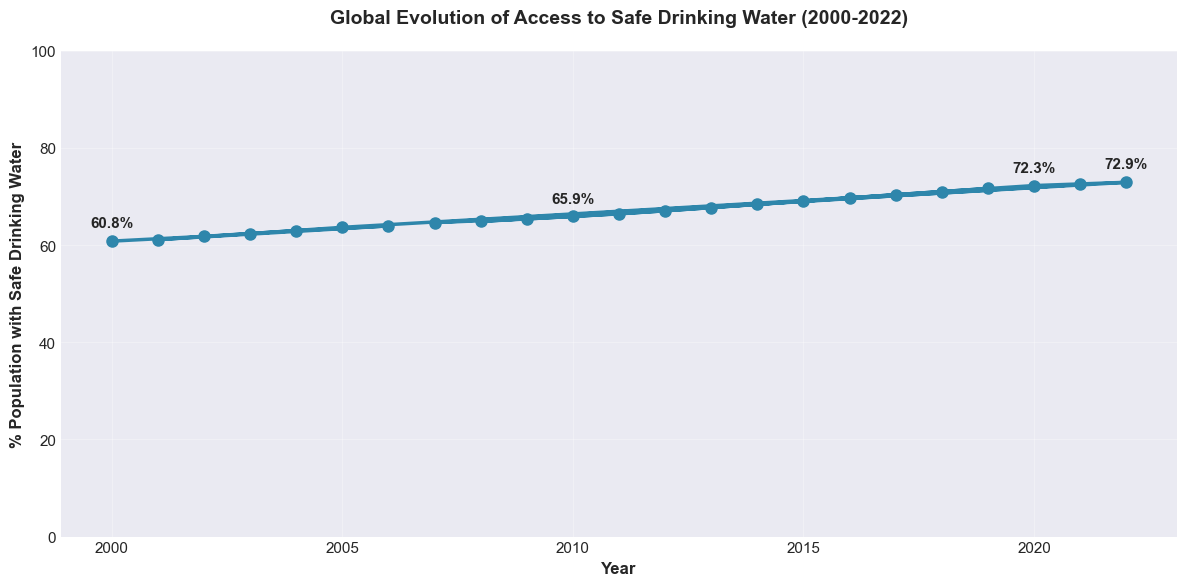

2000-2022: 60.8% -> 72.9%(+12.1points)


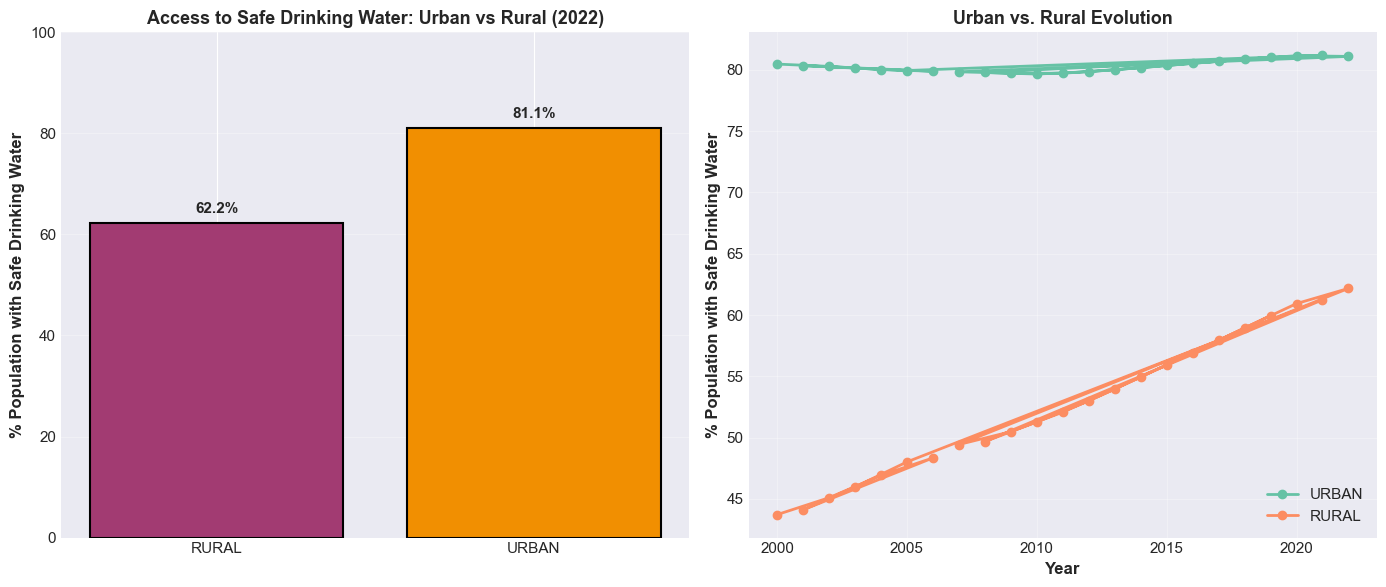

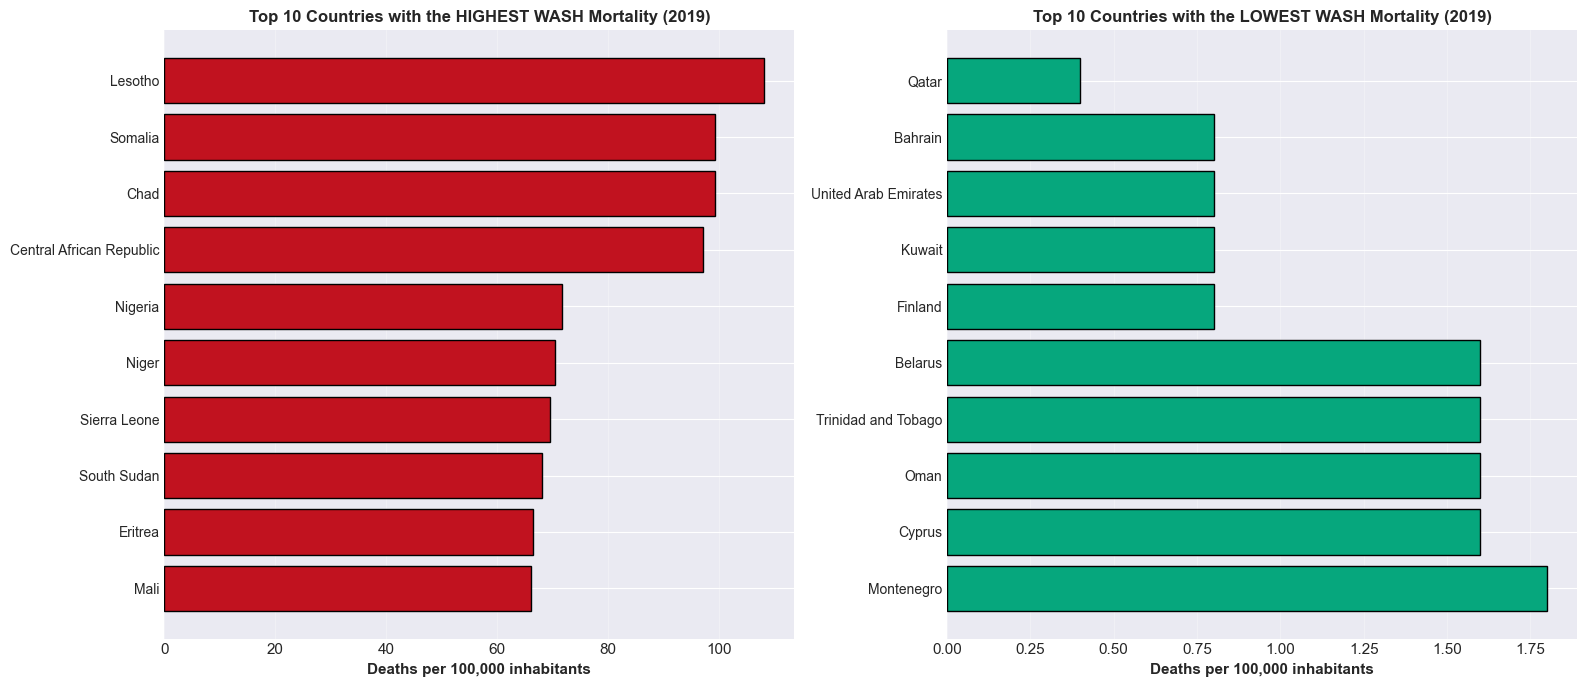

Country with highest mortality: Lesotho (108.1/100k)
Country with lowest mortality: Qatar (0.400/100k)


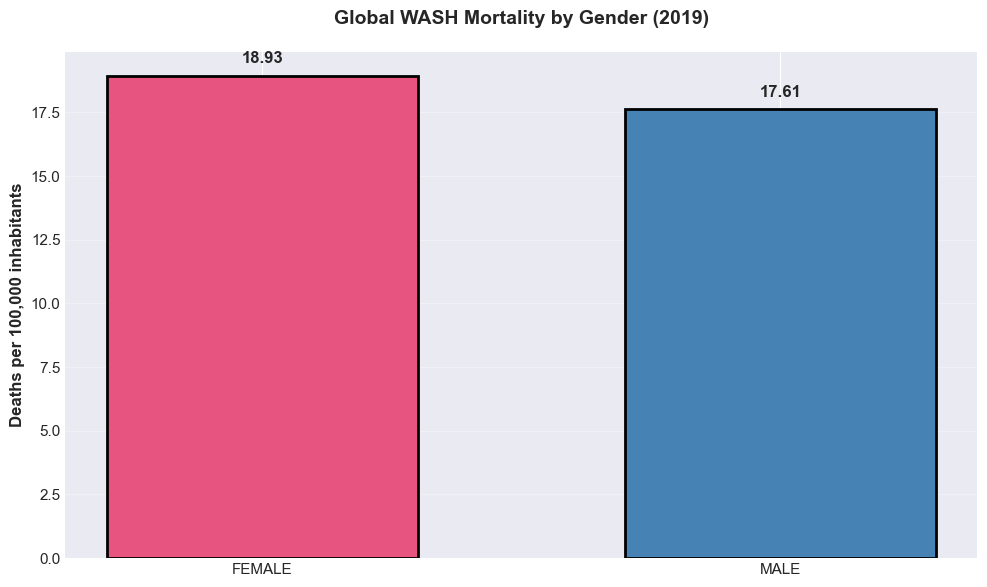

Difference between genders: 1.32 deaths/100k


In [137]:

print("EDA VISUALIZATION")
#We only take take global level and total
#From waterStd we filter only 'GLOBAL' and 'TOTAL'
waterGlobal = waterStd[(waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'] == 'TOTAL')].copy()
#Create a figure
fig, ax = plt.subplots(figsize=(12,6))

#Lineal chart
ax.plot(
    waterGlobal['year'],    #X -> years
    waterGlobal['water_pct'], #Y -> %drinking water
    marker = 'o', #point
    linewidth=2.5,
    markersize=8, #size
    color='#2E86AB'
)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
ax.set_title(
    'Global Evolution of Access to Safe Drinking Water (2000-2022)',
    fontsize=14, fontweight='bold', pad=20
)
ax.grid(True, alpha=0.3) 
ax.set_ylim([0,100]) #percentages

for year in [2000, 2010, 2020, 2022]:
    #Select the row for that year
    row = waterGlobal[waterGlobal['year'] == year]
    #This ensures that if the dataset doesn’t have data for a given year, the code skips it
    if not row.empty:
        #Extract the percentage value
        val = row['water_pct'].values[0] #Wr take the value calculated
        #We plot the the year and value in order to see how's changing 
        ax.annotate(f'{val:.1f}%', xy=(year, val), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontweight='bold')
#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

initial = waterGlobal[waterGlobal['year'] == 2000]['water_pct'].values[0]
end = waterGlobal[waterGlobal['year'] == 2022]['water_pct'].values[0]
print(f"2000-2022: {initial:.1f}% -> {end:.1f}%(+{end-initial:.1f}points)")

#Urban vs rural
#We filter year == 2022, geo_type = GLOBAL, urbanization in URBAN and RURAL
water2022 = waterStd[(waterStd['year'] == 2022) & (waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'].isin(['URBAN','RURAL']))]
fig, axes = plt.subplots(1,2, figsize=(14,6))

#axes[0] create vertical lines
# x-> urban and rural
axes[0].bar(water2022['urbanization'], water2022['water_pct'], color=['#A23B72', '#F18F01'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
axes[0].set_title('Access to Safe Drinking Water: Urban vs Rural (2022)', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

for i,(urb,pct) in enumerate(zip(water2022['urbanization'],water2022['water_pct'])):
    axes[0].text(i, pct + 2, f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=11)

#We obtain de data for each urban and rural, each year
waterUrbTime = waterStd[(waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'].isin(['URBAN', 'RURAL']))]

#Plot two series Urban and Rural
for urb in ['URBAN', 'RURAL']:
    #Filter time series
    data = waterUrbTime[waterUrbTime['urbanization'] == urb]
    #Drawing a line 
    axes[1].plot(data['year'], data['water_pct'], marker='o', label=urb, linewidth=2)

axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
axes[1].set_title('Urban vs. Rural Evolution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

#Top 10 mortality
#from mortStd we filter geo_type == country and sex
#What we got is an array for each country with their mortality
mortCountries = mortStd[(mortStd['geo_type'] == 'COUNTRY') & (mortStd['sex'] == 'TOTAL')].copy()
top10Worst = mortCountries.nlargest(10,'wash_mortality_per_100k')
top10Best = mortCountries.nsmallest(10,'wash_mortality_per_100k')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#Chart configuration Highest mortality
axes[0].barh(range(10), top10Worst['wash_mortality_per_100k'], color='#C1121F', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top10Worst['country'], fontsize=10)
axes[0].set_xlabel('Deaths per 100,000 inhabitants', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Countries with the HIGHEST WASH Mortality (2019)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

#Lowest mortality
#Draw a line for the 10 countries with the lowest mortality
axes[1].barh(range(10), top10Best['wash_mortality_per_100k'], color='#06A77D', edgecolor='black')
axes[1].set_yticks(range(10))
#Label each bar with the corresponding country name
axes[1].set_yticklabels(top10Best['country'], fontsize=10)
axes[1].set_xlabel('Deaths per 100,000 inhabitants', fontsize=11, fontweight='bold')
axes[1].set_title('Top 10 Countries with the LOWEST WASH Mortality (2019)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

print("Country with highest mortality:", top10Worst.iloc[0]['country'], f"({top10Worst.iloc[0]['wash_mortality_per_100k']:.1f}/100k)")
print("Country with lowest mortality:", top10Best.iloc[0]['country'], f"({top10Best.iloc[0]['wash_mortality_per_100k']:.3f}/100k)")

#Genre
#Filter geo_type = 'GLOBAL' and sex in FEMALE and MALE
mortGender = mortStd[(mortStd['geo_type'] == 'GLOBAL') & (mortStd['sex'].isin(['FEMALE', 'MALE']))]
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'FEMALE': '#E75480', 'MALE': '#4682B4'}
for sex in ['FEMALE', 'MALE']:
    data = mortGender[mortGender['sex'] == sex]
    ax.bar(sex, data['wash_mortality_per_100k'].values[0], color=colors[sex], edgecolor='black', linewidth=2, width=0.6)
    ax.text(sex, data['wash_mortality_per_100k'].values[0] + 0.5, f"{data['wash_mortality_per_100k'].values[0]:.2f}", ha='center', fontweight='bold', fontsize=12)

ax.set_ylabel('Deaths per 100,000 inhabitants', fontsize=12, fontweight='bold')
ax.set_title('Global WASH Mortality by Gender (2019)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

diff = abs(mortGender[mortGender['sex']=='FEMALE']['wash_mortality_per_100k'].values[0] - mortGender[mortGender['sex']=='MALE']['wash_mortality_per_100k'].values[0])
print(f"Difference between genders: {diff:.2f} deaths/100k")

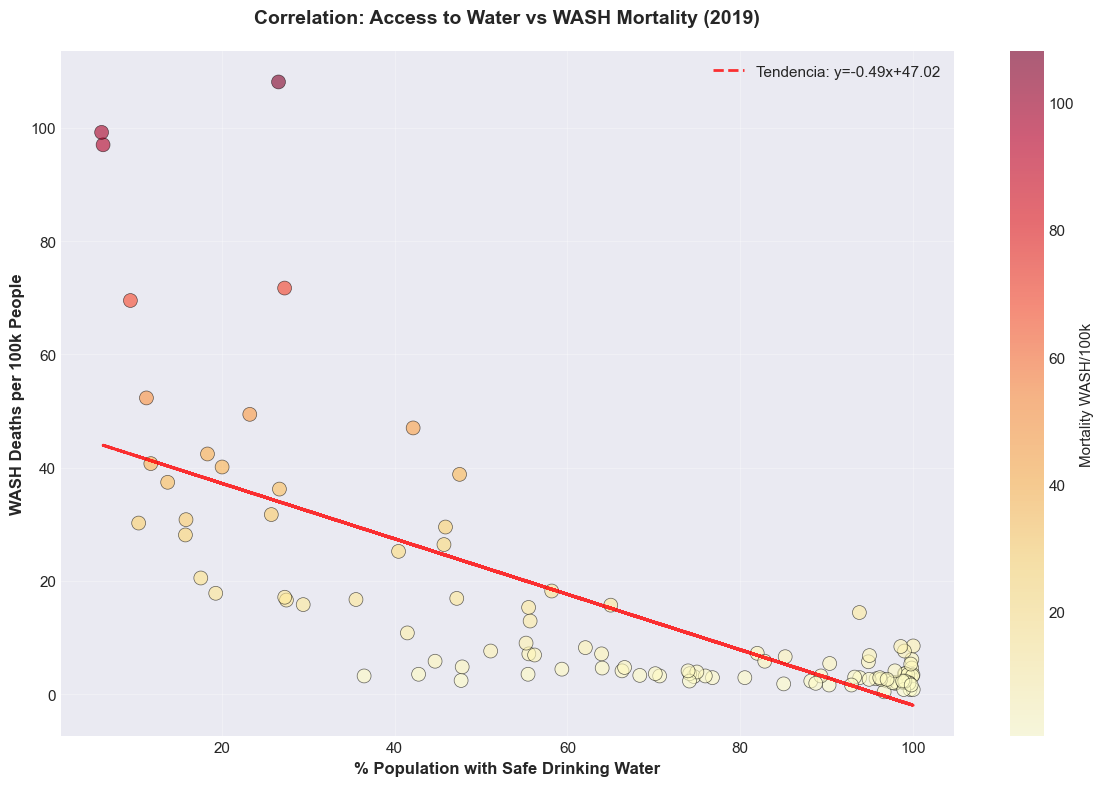

Pearson correlation: -0.718
-> STRONG NEGATIVE correlation: More safe water = Lower mortality


C:\Users\tonin\AppData\Local\Temp\ipykernel_14360\796988348.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\tonin\AppData\Local\Temp\ipykernel_14360\796988348.py:74: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


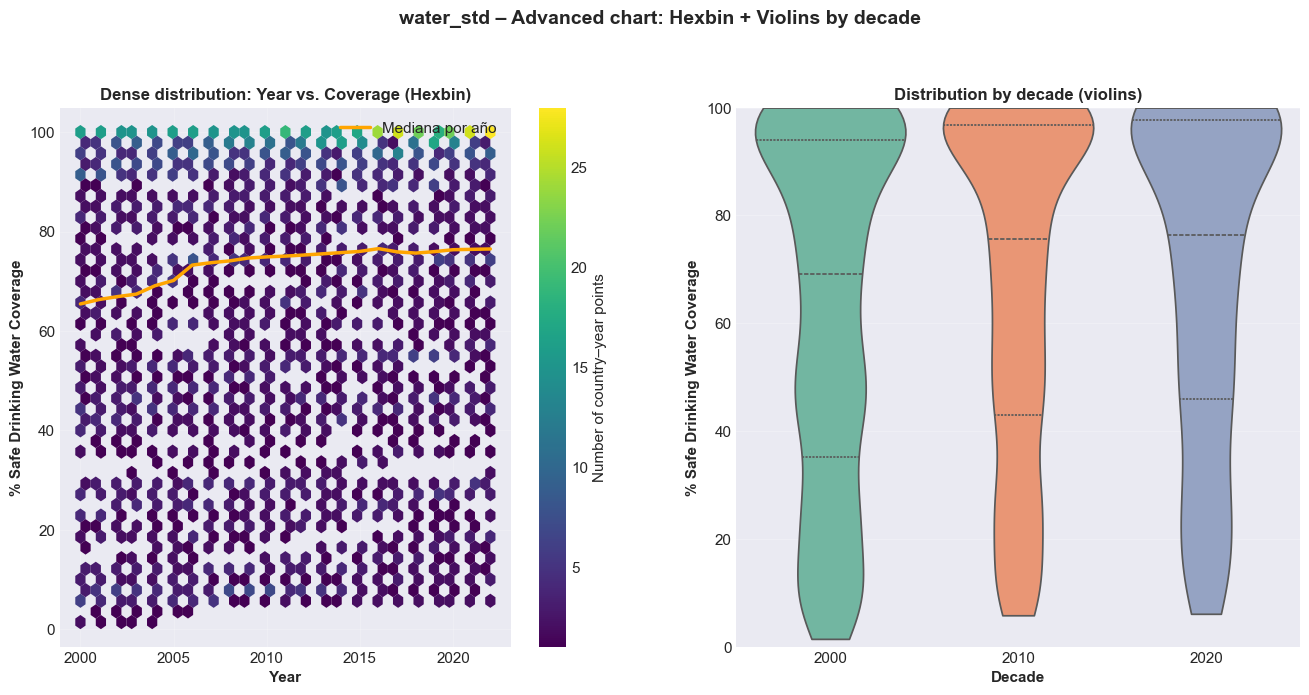

In [138]:
#FILTER == 2019
water2019Contries = waterStd[(waterStd['year'] == 2019) & (waterStd['geo_type'] == 'COUNTRY') & (waterStd['urbanization'] == 'TOTAL')][['country', 'water_pct']]
mort2019Contries =  mortStd[(mortStd['geo_type'] == 'COUNTRY') & (mortStd['sex'] == 'TOTAL')][['country', 'wash_mortality_per_100k']]
merged = pd.merge(water2019Contries, mort2019Contries, on='country', how='inner')

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(merged['water_pct'], merged['wash_mortality_per_100k'], alpha=0.6, s=100, c=merged['wash_mortality_per_100k'], cmap='YlOrRd', edgecolors='black', linewidth=0.5)
z = np.polyfit(merged['water_pct'], merged['wash_mortality_per_100k'], 1)
p = np.poly1d(z)
ax.plot(merged['water_pct'], p(merged['water_pct']), "r--", alpha=0.8, linewidth=2, label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
ax.set_xlabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
ax.set_ylabel('WASH Deaths per 100k People', fontsize=12, fontweight='bold')
ax.set_title('Correlation: Access to Water vs WASH Mortality (2019)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.colorbar(scatter, ax=ax, label='Mortality WASH/100k')
plt.tight_layout()
plt.show()
corr = merged['water_pct'].corr(merged['wash_mortality_per_100k'])
print(f"Pearson correlation: {corr:.3f}")
if corr < -0.7:
    print("-> STRONG NEGATIVE correlation: More safe water = Lower mortality")
elif corr < -0.3:
    print("-> MODERATE NEGATIVE correlation")
else:
    print("-> WEAK correlation")

ws_countries = waterStd[
    (waterStd['geo_type'] == 'COUNTRY') &
    (waterStd['urbanization'] == 'TOTAL')
][['country', 'year', 'water_pct']].dropna()

if len(ws_countries) > 0:
    fig = plt.figure(figsize=(16, 7))

    # HEXBIN: densidad año vs % cobertura
    ax_a = plt.subplot(1, 2, 1)
    #Plot a hexbin to show point density
    hb = ax_a.hexbin(
        #x axis year
        ws_countries['year'].astype(float),
        #y-axis safe drinking water
        ws_countries['water_pct'].astype(float),
        gridsize=40, cmap='viridis', mincnt=1, linewidths=0.2, edgecolors=None
    )
    #density, number of countries
    cb = plt.colorbar(hb, ax=ax_a, label='Number of country–year points')
    ax_a.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax_a.set_ylabel('% Safe Drinking Water Coverage', fontsize=11, fontweight='bold')
    ax_a.set_title('Dense distribution: Year vs. Coverage (Hexbin)', fontsize=12, fontweight='bold')
    ax_a.grid(True, alpha=0.2)

    # Tendencia global (mediana móvil)
    #Medican coverage per year
    tmp = ws_countries.groupby('year')['water_pct'].median().reset_index()
    ax_a.plot(tmp['year'], tmp['water_pct'], color='orange', linewidth=2.5, label='Mediana por año')
    ax_a.legend()

    '''
        This chart shows only 2019: each red circle is a country. Moving right means a larger share of people have 
        safe drinking water; moving up means more WASH deaths per 100k. The dashed red trendline slopes 
        downward, so 2019 has a negative correlation: countries with more safe water tend to have fewer deaths. 
        The “good zone” is the bottom-right (high water access, low deaths), while the “risk zone” is the top-left 
        (low access, high deaths). Any dots sitting unusually high compared with neighbors are likely outliers that 
        may have other problems beyond water access.
    '''
    #Violin
    ax_b = plt.subplot(1, 2, 2)
    ws_dec = ws_countries.copy()
    ws_dec['decade'] = (ws_dec['year'] // 10) * 10
    order_dec = sorted(ws_dec['decade'].unique())
    #Violin to show distributon per decade
    sns.violinplot(
        data=ws_dec, x='decade', y='water_pct', order=order_dec,
        inner='quartile', cut=0, scale='width', palette='Set2', ax=ax_b
    )
    ax_b.set_xlabel('Decade', fontsize=11, fontweight='bold')
    ax_b.set_ylabel('% Safe Drinking Water Coverage', fontsize=11, fontweight='bold')
    ax_b.set_title('Distribution by decade (violins)', fontsize=12, fontweight='bold')
    ax_b.set_ylim(0, 100)
    ax_b.grid(True, axis='y', alpha=0.25)

    plt.suptitle('water_std – Advanced chart: Hexbin + Violins by decade',
             fontsize=14, fontweight='bold', y=1.02)

Left (hexbin):
Each hexagon summarizes many “country–year” points. Brighter = more countries at that level. The yellow line is the global median each year. It moves up from about 65% to 75% between 2000 and 2022, so the world is improving. Most points sit between 70% and 100%

Right (violins by decade):
On the right, each violin shows a decade’s distribution of safe water coverage. Higher parts mean higher values, the wider the violin at a given height, the more countries have that level. The thin lines mark the median and middle 50%. In our chart, 2010s/2020s sit higher than 2000s (better overall), but a lower tail remains—some countries are still very low

In short:
Global access to safe drinking water is getting better, but not evenly. Many countries are near universal access, while a smaller group still lags far behind and needs focused support

C:\Users\tonin\AppData\Local\Temp\ipykernel_14360\273499983.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


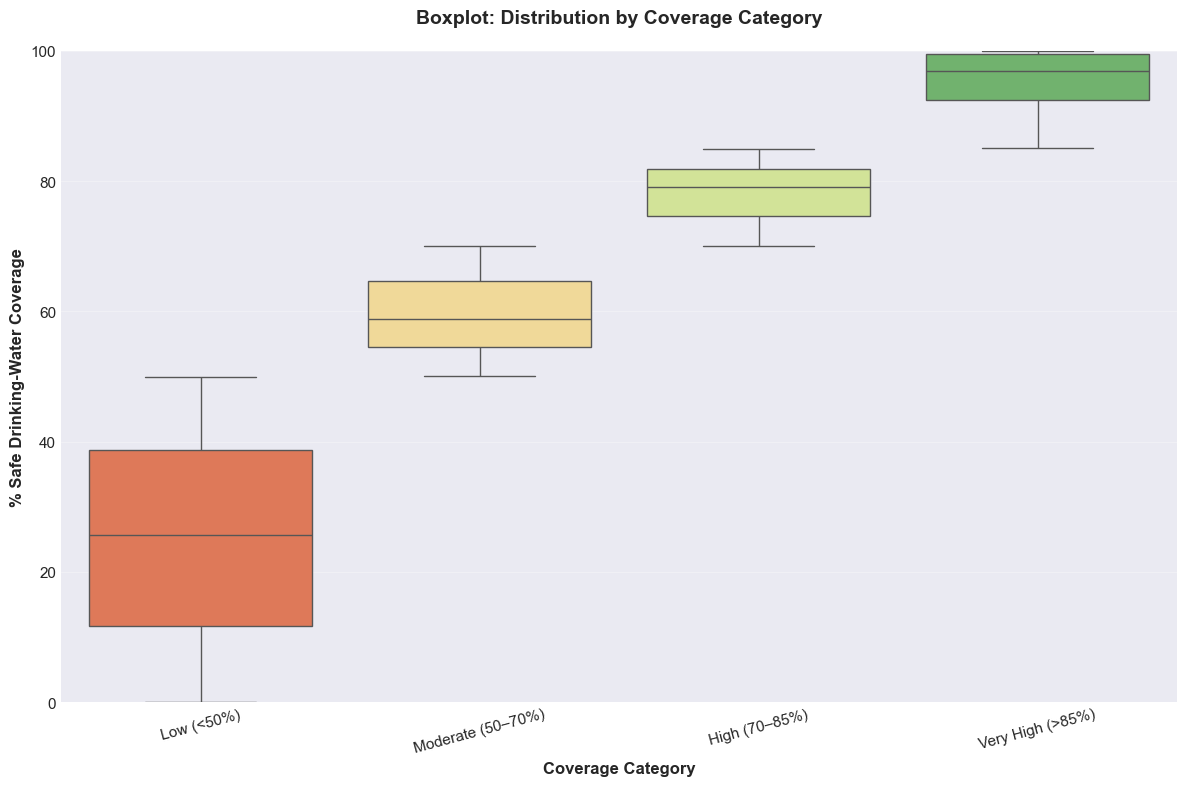

In [139]:
#Prepare data for boxplot
water_box = waterStd[waterStd['geo_type'] == 'COUNTRY'].copy()
water_box = water_box.dropna(subset=['water_pct', 'year', 'urbanization'])

if len(water_box) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #Boxplot: Distribution by coverage categories
    water_box_cat = water_box.copy()
    water_box_cat['coverage_category'] = pd.cut(
        water_box_cat['water_pct'],
        bins=[0, 50, 70, 85, 100],
        labels=['Low (<50%)', 'Moderate (50–70%)', 'High (70–85%)', 'Very High (>85%)']
    )
    water_box_cat = water_box_cat.dropna(subset=['coverage_category'])
    
    sns.boxplot(
        data=water_box_cat, x='coverage_category', y='water_pct',
        palette='RdYlGn', ax=ax
    )
    ax.set_xlabel('Coverage Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('% Safe Drinking-Water Coverage', fontsize=12, fontweight='bold')
    ax.set_title('Boxplot: Distribution by Coverage Category', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Each box represents a group (Low, Moderate, High, Very High). A higher box means more safe-water coverage, and the middle line is the group’s typical value. The size of the box shows how similar countries are: a bigger box means countries in that group are very different from each other; a smaller box means they’re more alike. In this chart, Low sits low and is large (little water, very uneven), while High and Very High sit higher and are smaller (more water, more consistent)

In [140]:
# Advanced Country Analysis: Status & Trend Classification (2000–2022)
#Filters country-level time series from `waterStd` (geo_type == 'COUNTRY')
#    latest_coverage: most recent % safe water coverage
#    improvement_2000_2022: delta between first and last observed values
#    annual_rate: average yearly change (pp/year) over the observed span
# Classifies each country into categories by latest coverage:
#    LEADER (>= 95), ON_TRACK (>= 70), MODERATE (>=50), else LAGGING
# Sorts the result by latest coverage and prints the bottom/top 10
print(" ADVANCED ANALYSIS: FACTORS & FORECASTS ")
#Filter 
waterCountries = waterStd[waterStd['geo_type'] == 'COUNTRY'].copy()
countryAnalysis = []

for country in waterCountries['country'].unique():
    data = waterCountries[waterCountries['country'] == country].sort_values('year')

    if len(data) < 5:
        continue
    
    # most recent % coverage
    latest = data.iloc[-1]['water_pct']
    # earliest % coverage
    earliest = data.iloc[0]['water_pct']
    # net change in percentage points
    improvement = latest - earliest
    #Span of available years and average yearly change (pp/year)
    yearSpan = data['year'].max() - data['year'].min()
    annual_rate = improvement / yearSpan if yearSpan > 0 else 0

    if latest >= 95:
        category = "LEADER"
    elif latest >= 70:
        category = "ON_TRACK"
    elif latest >= 50:
        category = "MODERATE"
    else:
        category = "LAGGING"

    countryAnalysis.append({
        'country': country,
        'latest_coverage': latest,
        'improvement_2000_2022': improvement,
        'annual_rate': annual_rate,
        'category': category
    })

analysisDf = pd.DataFrame(countryAnalysis).sort_values('latest_coverage')

print("\nMOST CRITICAL COUNTRIES (LAGGING):")
#the most recent % of people with safe drinking water for that country
#the average change per year in coverage, measured in percentage points per year
print(analysisDf.head(10)[['country', 'latest_coverage', 'category', 'annual_rate']])
print("\nMOST ADVANCED COUNTRIES (LEADERS):")
print(analysisDf.tail(10)[['country', 'latest_coverage', 'category', 'annual_rate']])


 ADVANCED ANALYSIS: FACTORS & FORECASTS 

MOST CRITICAL COUNTRIES (LAGGING):
                             country  latest_coverage category  annual_rate
74                            Tuvalu         10.46536  LAGGING     0.233614
35          Central African Republic         11.25368  LAGGING     0.356151
65                      Sierra Leone         12.24918  LAGGING     0.460454
37                              Chad         17.58653  LAGGING     0.666634
2                           Kiribati         20.36983  LAGGING     0.687642
21                             Nepal         23.16236  LAGGING    -0.083984
40  Democratic Republic of the Congo         24.15145  LAGGING     1.068004
58       United Republic of Tanzania         25.47814  LAGGING     1.158097
14  Lao People's Democratic Republic         26.98744  LAGGING     1.216705
70                              Togo         33.85986  LAGGING     1.539085

MOST ADVANCED COUNTRIES (LEADERS):
                          country  latest_coverage 

In [141]:
#Simple Linear Regression
# Picks the bottom 5 and top 5 countries from `analysisDf` (by its current ordering).
# For each selected country, uses its historical % safe drinking water coverage
#  ("water_pct") across years from "waterCountries".
# Fits a simple Linear Regression (water_pct ~ year) and forecasts coverage for 2025 and 2030.
# Clips predictions to the valid range [0, 100].
#Reports the latest observed coverage ("current"), forecasts, the slope ("velocity"),
# and the country category from `analysisDf`.
# 1)Data selection: filter each country’s time series from `waterCountries`.
# 2)Modeling: fit sklearn’s LinearRegression on (year → water_pct).
# 3)Inference: predict for target years (2025, 2030); clip to [0, 100].

def forecast_coverage(years, values, targetYear=2030):
    X = np.array(years).reshape(-1, 1)
    y = np.array(values)

    model = LinearRegression()
    model.fit(X, y)

    pred = model.predict(np.array([[targetYear]]))[0]
    pred = np.clip(pred, 0, 100)

    return pred, model.coef_[0]

worst_countries = analysisDf.head(5)['country'].tolist()
best_countries = analysisDf.tail(5)['country'].tolist()
countries_to_forecast = worst_countries + best_countries

forecasts = []

for country in countries_to_forecast:
    data = waterCountries[waterCountries['country'] == country].sort_values('year')
    if len(data) >= 5:
        years = data['year'].values
        values = data['water_pct'].values

        pred_2025, vel_2025 = forecast_coverage(years, values, 2025)
        pred_2030, vel_2030 = forecast_coverage(years, values, 2030)

        forecasts.append({
            'country': country,
            'current': values[-1],
            'forecast_2025': pred_2025,
            'forecast_2030': pred_2030,
            'velocity': vel_2030,
            'category': analysisDf[analysisDf['country'] == country]['category'].values[0] if len(analysisDf[analysisDf['country'] == country]) > 0 else 'UNKNOWN'
        })

forecasts_df = pd.DataFrame(forecasts)
print("\nFORECASTS FOR 2025–2030:")
print(forecasts_df)
print("\nWARNING: These forecasts assume a continuation of current trends")




FORECASTS FOR 2025–2030:
                    country    current  forecast_2025  forecast_2030  \
0                    Tuvalu   10.46536       8.241445       8.331210   
1  Central African Republic   11.25368       5.929132       5.196879   
2              Sierra Leone   12.24918      10.831715      11.841035   
3                      Chad   17.58653       9.003828       9.242210   
4                  Kiribati   20.36983      14.141166      14.846465   
5               New Zealand  100.00000     100.000000     100.000000   
6                   Iceland  100.00000     100.000000     100.000000   
7                    Kuwait  100.00000     100.000000     100.000000   
8                   Hungary  100.00000      98.370016     100.000000   
9                    France  100.00000      99.634791     100.000000   

   velocity category  
0  0.017953  LAGGING  
1 -0.146451  LAGGING  
2  0.201864  LAGGING  
3  0.047676  LAGGING  
4  0.141060  LAGGING  
5  0.827773   LEADER  
6  0.490229   LEADER

This table is my simple forecast of safe drinking-water coverage by country. For each country, we show the latest value , our estimates for 2025 and 2030, the velocity (how many percentage points it changes per year), and the category (leader or lagging). A positive velocity means it’s getting better; a negative one means it’s getting worse. The forecasts come from a straight-line fit to past data, and we cap results between 0 and 100. In plain terms: countries already near 100% stay there, countries with low coverage improve only a little and remain behind; one case (Central African Republic) even trends down. This is just a baseline real outcomes can change with investment, income, or government actions.

**Conclusion**
Access to safe drinking water has improved overall, with many countries now in the High and Very High groups and those groups are also more consistent across countries. The Low group remains both lower and more uneven, signaling pockets of severe under-coverage. Priorities should focus on lifting countries in the Low/Moderate bands and reducing their variability, while sustaining near-universal access among leaders